In [43]:
# JG 11/15/17

import pandas as pd
import numpy as np
import math
import scipy.stats as stats


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

2/12/18 Notes:
soil type doesn't seem to drive alpha diversity, not surprising, seems like it's mostly a depth dependent thing. I can try to model both with categorical + linear thing.

In [23]:
map_df = pd.read_csv('../Metadata/ibp_metadata_2.6.18_version.txt', sep='\t')
chao1_data = '../Seq_data/vsearch/alpha/alpha_div_collated/chao1.txt'
chao1_df = pd.read_csv(chao1_data, sep='\t')

# Subset the last round, average all bootstrap iterations and delete the seq/sample and iteration columns
chao1_df = chao1_df.loc[100:]
average_chao1 = chao1_df.mean(axis=0)
average_chao1 = average_chao1[2:]

In [21]:
# Check avg-chao indices = mapdf row indices?

def subset_index(index1, filter_index):
    """Subsets index1 to only those values found in filter index and returns the new index.
    Only supports index by columns right now. General version needed? Would have options for rows, columns or index.
    Actually this works if you pass the correct options ahead of time. 
    """
    return [x for x in index1 if x in filter_index.values]
    
    
columns = subset_index(average_chao1.index, map_df['#SampleID'])
average_chao1 = average_chao1[columns]


In [38]:
# Test - ANOVA w/ soil type

map_df['USDA_Soil Series'].value_counts()
# groupby soil series, then get #sampleID column values for each group
groups = map_df.groupby('USDA_Soil Series')
soil_AD = {}
for name, group in groups:
    samples = group['#SampleID'].values
    group_AD = average_chao1[samples]
    group_AD = [x for x in group_AD.values if not np.isnan(x)]    
    soil_AD[name] = group_AD

stats.f_oneway(soil_AD['Hoopeston fine sandy loam '], soil_AD['Watseka loamy fine sand '], soil_AD['Selma loam ']) 

dict_keys(['Hoopeston fine sandy loam ', 'Watseka loamy fine sand ', 'Selma loam '])


F_onewayResult(statistic=4.0227442392048092, pvalue=0.019335513776562282)

In [42]:
# plot AD by soil type / violin plots:
#sns.violinplot(data=(soil_AD['Hoopeston fine sandy loam '], soil_AD['Watseka loamy fine sand '], soil_AD['Selma loam ']))

Text(0.5,0,'Depth (x 10 cm)')

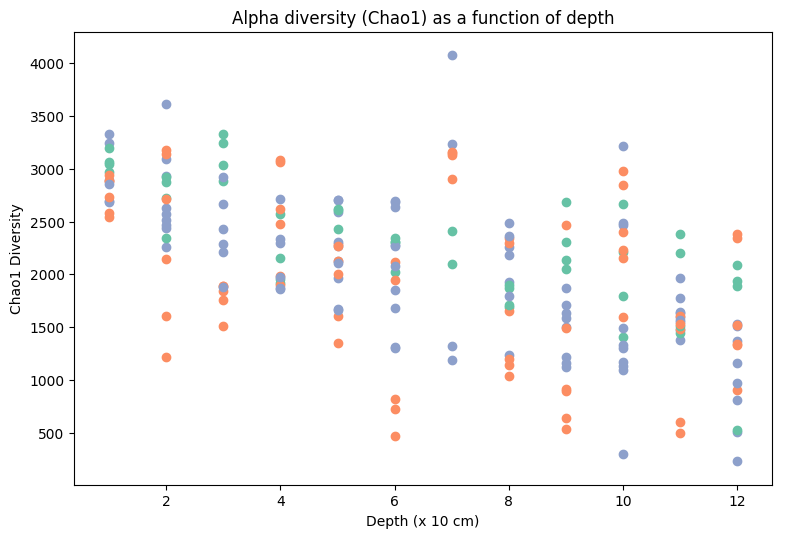

In [50]:
# AD vs depth, colored by soil series:

soiltype_dict = {'Hoopeston fine sandy loam ':sns.color_palette('Set2', 3)[0], 
                 'Watseka loamy fine sand ':sns.color_palette('Set2', 3)[1], 
                 'Selma loam ':sns.color_palette('Set2', 3)[2] }

f,ax = plt.subplots()
for i in average_chao1.items():
    if i[0].split('.')[0] != 'W11':
        if i[1] > 200:
            depth = i[0].split('.')[1]
            if len(depth) <4:
                depth = int(depth[1:])
                soil = map_df[ map_df['#SampleID'] == i[0]] ['USDA_Soil Series'].values[0]
                if soil in soiltype_dict.keys():
                    ax.scatter(depth, i[1], c=soiltype_dict[soil])#, color = inundation)#, cmap=c_map)

ax.set_title('Alpha diversity (Chao1) as a function of depth')
ax.set_ylabel('Chao1 Diversity')
ax.set_xlabel('Depth (x 10 cm)')
#f.savefig('../output/chao1_ad_vs_depth.png')
    

Text(0.5,0,'Depth (x 10 cm)')

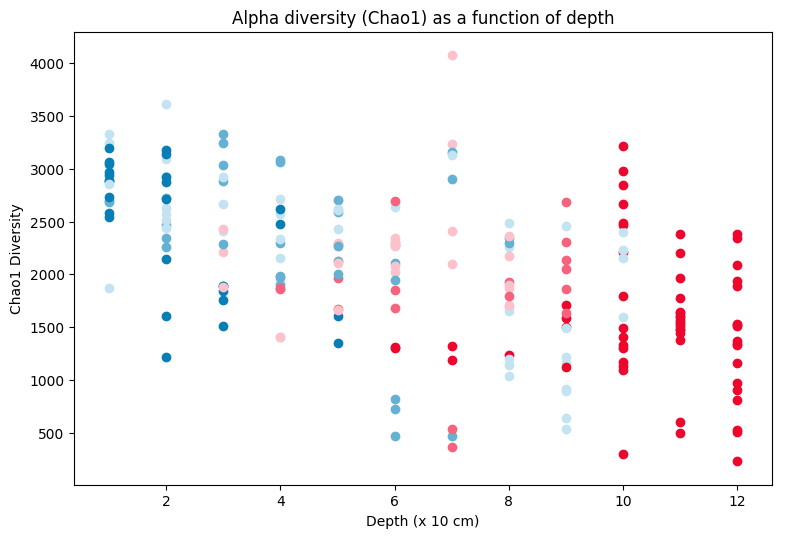

In [69]:
# Organize data by depth and inundation fraction:

cmap = ListedColormap(sns.diverging_palette(240, 10,s=99))


f, ax = plt.subplots()
for i in average_chao1.items():
    if i[0].split('.')[0] != 'W11':
        if i[1] > 200:
            depth = i[0].split('.')[1]
            if len(depth) <4:
                depth = int(depth[1:])
                inundation = map_df[ map_df['#SampleID'] == i[0]] ['Inundation_Frac'].values[0]
                ax.scatter(depth, i[1], c=cmap(inundation))#, color = inundation)#, cmap=c_map)

ax.set_title('Alpha diversity (Chao1) as a function of depth')
ax.set_ylabel('Chao1 Diversity')
ax.set_xlabel('Depth (x 10 cm)')
#f.savefig('../output/chao1_ad_vs_depth.png')
    

In [78]:
depth_list = []
inundation_list = []
chao1_list = []
for i in average_chao1.items():
    if i[0].split('.')[0] != 'W11':
        if i[1] > 200:
            depth = i[0].split('.')[1]
            if len(depth) < 4:
                depth_val = int(depth[1:])
                depth_list.append(depth_val)
                chao1_list.append(i[1])
                inundation_list.append(map_df[ map_df['#SampleID'] == i[0]] ['Inundation_Frac'].values[0])

sns.regplot(x=inundation_list, y=chao1_list, order=2)

TypeError: only integer scalar arrays can be converted to a scalar index

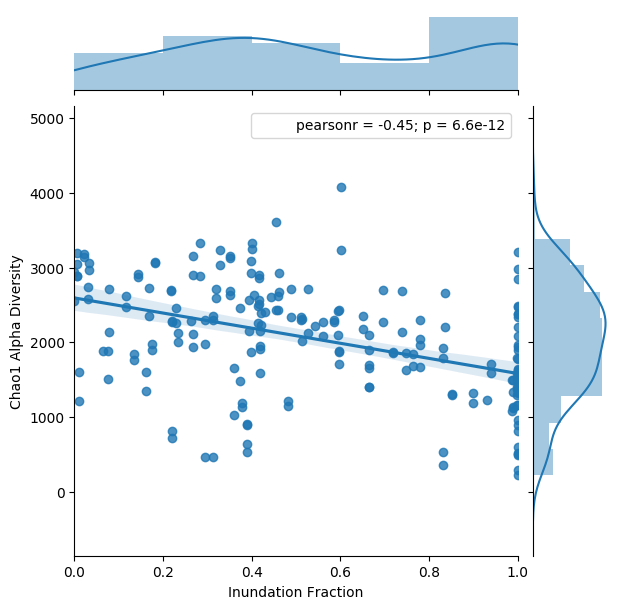

In [164]:
# Trying to redo this by inundation to see if it makes any sense to even show this?

chao_vals = []
inundation_vals = []

colors = sns.color_palette()
#f, ax = plt.subplots()
for i in average_chao1.items():
    if i[0].split('.')[0] != 'W11':
        if i[1] > 200:
            depth = i[0].split('.')[1]
            if len(depth) <4:
                depth = int(depth[1:])
                inundation = map_df[ map_df['#SampleID'] == i[0]] ['Inundation_Frac'].values[0]
                chao_vals.append(i[1])
                inundation_vals.append(inundation)
                #ax.scatter(inundation, i[1], c=colors[0])# c=cmap(inundation))#, color = inundation)#, cmap=c_map)
#ax.set_title('Alpha diversity (Chao1) as a function of inundation fraction')
#ax.set_ylabel('Chao1 Diversity')
#ax.set_xlabel('Inundation Fraction')
#ax.invert_yaxis()
f = sns.jointplot(x=np.asarray(inundation_vals), y=np.asarray(chao_vals), kind='reg', xlim=(0,1))
plt.xlabel('Inundation Fraction')
plt.ylabel('Chao1 Alpha Diversity')
f.savefig('./jointplot_ad_in.png')

In [150]:
inundation_vals

[1.0,
 0.99988583200000003,
 0.35220915600000002,
 0.83251512700000008,
 1.0,
 0.26692544800000001,
 0.59487384399999998,
 0.99988583200000003,
 0.45473227500000002,
 0.21908893699999998,
 0.22959241899999999,
 0.39810480600000003,
 0.41774175099999999,
 0.54269893800000002,
 0.41608631100000004,
 0.83679643799999992,
 0.76389998900000011,
 1.0,
 0.31967119500000002,
 0.59487384399999998,
 0.38874300700000003,
 0.29512501399999996,
 1.0,
 0.51409978299999992,
 0.6011531,
 0.66542984399999994,
 0.7803973059999999,
 0.99960041099999997,
 1.0,
 0.93109944099999997,
 0.031510445999999998,
 0.71908893699999998,
 0.0059938350000000003,
 1.0,
 1.0,
 0.94028998699999999,
 0.35220915600000002,
 1.0,
 0.94028998699999999,
 0.21908893699999998,
 0.74820184999999995,
 0.99058111700000007,
 0.22959241899999999,
 0.77994063200000008,
 0.1623473,
 0.52625870500000005,
 0.48116223299999999,
 0.078547778999999998,
 0.0059938350000000003,
 0.52625870500000005,
 0.011017239,
 0.033508390999999998,
 0.416

In [31]:
map_df['#SampleID']

,#SampleID,BarcodeSequence,LinkerPrimerSequence,Well,WLWNum,MicroNum,Cumm_Depth,Elevation,Depth,Soil_Type,...,Pb_Con,CU_Conc,Fe_Conc,Zn_Conc,Ca_Conc,K_conc,Mg_Conc,P_Conc,Na_Conc,Description
0,W1.D1.rA,ATGTTAGGGAAT,GTGTGYCAGCMGCCGCGGTAA,A1,1,1,2.727273,184.791,0.1,Lean Clay,...,22.724599,14.999288,3688.381322,64.563754,429.072734,238.107102,945.014054,244.932557,68.032562,W1_D1_rA
1,W1.D2.A,GCTAGTTATGGA,GTGTGYCAGCMGCCGCGGTAA,A2,1,2,16.363636,184.691,0.2,Lean Clay,...,6.237241,5.135522,2095.295000,23.334000,42.838531,104.372664,556.387133,226.666244,1936.190126,W1_D2_A
2,NA.Plate1A3,TCATCCGTCGGC,GTGTGYCAGCMGCCGCGGTAA,A3,1,3,30.000000,184.591,0.3,Lean Clay,...,2.915938,5.176014,1513.311000,7.517983,6.883709,88.085820,431.046610,87.975857,24.346202,N/A.Plate1A3
3,W1.D4.A,ATTTGGCTCTTA,GTGTGYCAGCMGCCGCGGTAA,A4,1,4,39.310345,184.491,0.4,Lean Clay,...,2.528242,4.258032,1735.524000,66.719966,195.711379,132.756535,938.953998,49.558536,34.832994,W1_D4_A
4,W1.D5.A,GATCCGGCAGGA,GTGTGYCAGCMGCCGCGGTAA,A5,1,5,49.655172,184.391,0.5,Lean Clay,...,13.613361,12.172000,1791.792000,40.318287,257.753549,450.417722,1094.239463,134.540061,42.902428,W1_D5_A
5,W1.D6.A,GTTAAGCTGACC,GTGTGYCAGCMGCCGCGGTAA,A6,1,6,60.000000,184.291,0.6,Lean Clay,...,2.901700,1.760984,2240.721000,14.133686,7.418723,117.433457,632.554754,159.276390,28.361103,W1_D6_A
6,W1.D7.A,CCTATTGCGGCC,GTGTGYCAGCMGCCGCGGTAA,A7,1,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,W1_D7_A
7,W1.D8.A,CAATAGAATAAG,GTGTGYCAGCMGCCGCGGTAA,A8,1,8,75.000000,184.091,0.8,Fat Clay,...,15.733764,17.627952,3417.195000,35.472045,298.983851,289.130264,1693.993421,196.773125,64.082716,W1_D8_A
8,W1.D9.A,ACATAGCGGTTC,GTGTGYCAGCMGCCGCGGTAA,A9,1,9,90.000000,183.991,0.9,Fat Clay,...,6.857421,14.483521,6269.399000,38.088714,15.843846,459.743157,1487.785572,184.637545,35.663205,W1_D9_A
9,W1.D10.A,GCGTGGTCATTA,GTGTGYCAGCMGCCGCGGTAA,A10,1,10,100.000000,183.891,1.0,Fat Clay,...,6.329584,9.862377,4352.933000,38.886153,391.689573,352.876326,2862.797306,256.000649,72.181690,W1_D10_A


# Initial Toggling Analysis

In [110]:
# Importing data
# what to do? Compare toggling frequency vs. AD and togglefreq vs distance to water table during sampling?
toggle_data = pd.read_csv('../toggle_per.csv')
new_data = toggle_data['toggle_period_seconds'].values
new_data = [value for value in new_data if not math.isnan(value)]
new_data = [value/86400 for value in new_data]


# Add a simplified name column to the toggle data
name_col = []
for i,row in toggle_data.iterrows():
    #print(str(row['section'].split('.')[0])
    new_index = row['well'][2:] + '.D' +str(row['section'])[:-2]
    name_col.append(new_index)
toggle_data['name'] = name_col
toggle_data['time/days'] = toggle_data['toggle_period_seconds']/86400

In [113]:
# Now we can plot vs toggle period.
# plot 1. toggle vs. distance to groundwater. aka does this capture something?
map_df.columns

Index(['#SampleID', 'BarcodeSequence', 'LinkerPrimerSequence', 'Well',
       'WLWNum', 'MicroNum', 'Cumm_Depth', 'Elevation', 'Depth', 'Soil_Type',
       'Dist_Ext_WT', 'Inundation_Frac', 'Dry_Frac', 'Pb_Con', 'CU_Conc',
       'Fe_Conc', 'Zn_Conc', 'Ca_Conc', 'K_conc', 'Mg_Conc', 'P_Conc',
       'Na_Conc', 'Description'],
      dtype='object')

In [126]:
# Let's make a quick comparison dataset:
toggle_vals = []
WT_dist_vals = []
for i,row in toggle_data.iterrows():
    #print(row['name'])
    WT_dist = map_df[map_df['#SampleID'].str.contains(row['name'])]['Dist_Ext_WT'].values[0]
    if not math.isnan(WT_dist):
        toggle_vals.append(row['time/days'])
        WT_dist_vals.append(WT_dist)

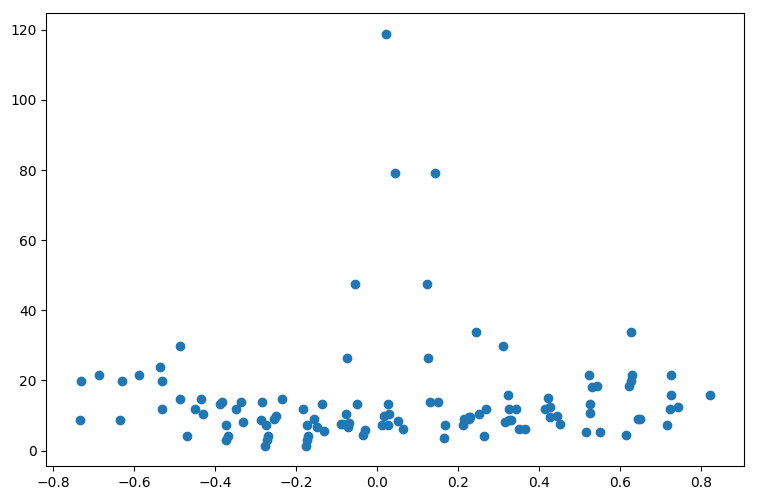

In [127]:
# Checking to see whether this is correlated with distance to the water table. It's not. I'm not actully sure if this captures anything but I will at least try with the AD data.
plt.scatter(WT_dist_vals, toggle_vals)

(-0.086525018985772723, 0.2117653609369734)

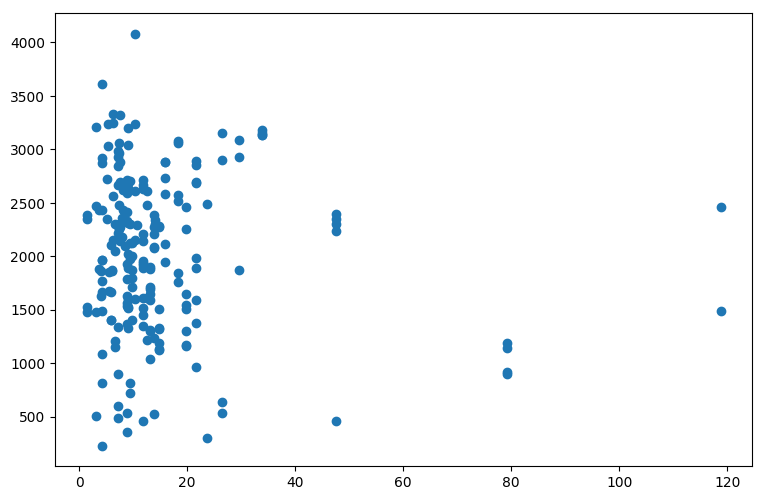

In [145]:
# Plotting AD vs. characteristic wetting/drying time
toggle_values_AD = []
chao_values = []

# group
for i in average_chao1.items():
    # Ignore no sensor data:
    if i[0].split('.')[0] != 'W11':
        # Ignore super low diversity samples:
        if i[1] > 200:
            name = i[0].rsplit('.', 1)[0]
            if name in toggle_data['name'].values:
                toggle = toggle_data[toggle_data['name'] == name]['time/days'].values[0]
                if not np.isnan(toggle):
                    chao_values.append(i[1])
                    toggle_values_AD.append(toggle_data[toggle_data['name'] == name]['time/days'].values[0])

f,ax= plt.subplots()
ax.scatter(toggle_values_AD, chao_values)
stats.pearsonr(toggle_values_AD, chao_values)

In [131]:
toggle_data

,well,core,section,cum_depth_cm,bottom_elev_m,top_elev_m,toggle_period_seconds,name,time/days
0,WLW1,1.0,1.0,2.727273,184.848558,184.875830,1.864718e+06,W1.D1,21.582386
1,WLW1,1.0,2.0,16.363636,184.712194,184.848558,1.709325e+06,W1.D2,19.783854
2,WLW1,1.0,3.0,30.000000,184.575830,184.712194,9.323591e+05,W1.D3,10.791193
3,WLW1,2.0,4.0,39.310345,184.482727,184.575830,8.204760e+05,W1.D4,9.496250
4,WLW1,2.0,5.0,49.655172,184.379279,184.482727,7.597000e+05,W1.D5,8.792824
5,WLW1,2.0,6.0,60.000000,184.275830,184.379279,7.889192e+05,W1.D6,9.131010
6,WLW1,3.0,7.0,60.000000,184.275830,184.275830,6.409969e+05,W1.D7,7.418945
7,WLW1,3.0,8.0,75.000000,184.125830,184.275830,6.409969e+05,W1.D8,7.418945
8,WLW1,3.0,9.0,90.000000,183.975830,184.125830,5.697750e+05,W1.D9,6.594618
9,WLW1,4.0,10.0,100.000000,183.875830,183.975830,2.698934e+05,W1.D10,3.123766
